## Imports

In [1]:
# Internal Python packages
import os
import time
import math

# Custom packages
import data_loading as data_loader

# Data Handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# More Machine Learning Packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

## Part 1: Loading the Experiment(s) Data
Based on the data retrieved from `data_analysis.ipynb`, get that data into a format capable of being used by a Machine Learning model.

<span style="color: orange;">**Future Experiment:** Generating multiple months or simply estimating a year in advance.</span>

In [2]:
MODEL_DATA_DIRECTORY = '../model_data/wheat_model_data/'
TEST_SIZE = 0.2
OUTPUT_COLUMN_NAME = 'Price'
N_TREND_SAMPLES = 3

# Model Architecture
HEAD_SIZE = 64
HEAD_DIVISION_FACTOR = 1 # Cannot change since working with odd number of features
FF_DIM = 16
NUM_TRANSFORMERS = 20

# ML Optimizer
START_LR = 1e-8
PEAK_LR = 1e-6
FINAL_LR = 1e-7
CLIP_VALUE = 0.5 # Gradient Clipping (https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem)
DROP_OUT_RATE = 0.2

# Training
BATCH_SIZE = 1
NUM_EPOCHS = 30

#### Part 1.1: Loading the Data From `data_analysis.ipynb`

In [3]:
sample_file_path = os.path.join(MODEL_DATA_DIRECTORY, os.listdir(MODEL_DATA_DIRECTORY)[0])
sample_columns = pd.read_csv(sample_file_path).columns[1:] # Skip 'Unnamed: 0' column
sample_columns

Index(['Date', 'Price', 'Proteus2', 'Food Price Index', 'Cereals Price Index',
       'Wheat Futures', 'Harvest', 'Sentiment'],
      dtype='object')

In [4]:
data = data_loader.get_data_from_dir(MODEL_DATA_DIRECTORY, sample_columns)
D_MODEL = len(data.columns) - 1 # -1 for 'Date' column
NUM_HEADS = D_MODEL//HEAD_DIVISION_FACTOR

print("FEATURE_SIZE: ", D_MODEL)
print("NUM HEADS: ", NUM_HEADS)
data

FEATURE_SIZE:  7
NUM HEADS:  7


,Date,Price,Proteus2,Food Price Index,Cereals Price Index,Wheat Futures,Harvest,Sentiment
0,2002-11-01,0.307031,0.830354,0.496995,0.500708,0.460318,0.738739,1.0
1,2002-12-01,0.285422,0.883785,0.473780,0.449608,0.405733,0.730918,1.0
2,2003-01-01,0.318897,0.314423,0.399018,0.374836,0.352477,0.390485,1.0
3,2003-02-01,0.353945,0.368133,0.405947,0.370020,0.357385,0.383057,1.0
4,2003-03-01,0.368640,0.416001,0.374578,0.347719,0.327074,0.376625,1.0
...,...,...,...,...,...,...,...,...
900,2016-08-01,0.348200,0.678242,0.588079,0.458857,0.333606,0.756849,1.0
901,2016-09-01,0.364530,0.656036,0.623093,0.439521,0.360232,0.756083,1.0
902,2016-10-01,0.393514,0.634037,0.639507,0.463615,0.388047,0.755328,1.0
903,2016-11-01,0.404325,0.610774,0.654949,0.473455,0.401033,0.754534,1.0


#### Part 1.2: Formatting the Data for Input Into a Machine Learning Model

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        target = self.targets[idx]
        return torch.Tensor(sequence), torch.Tensor([target])  # Wrap target in an array for consistency


In [6]:
# Build the data into different sequence chunks (each of size N_TREND_SAMPLES)
input_sequences = [] # List of sub-lists; each sub-list contains N_TREND_SAMPLES consecutive data samples
target_prices = [] # List of target prices corresponding to the next time step after the final sample in the above sequence

# Data is irrelevant to analysis
data.drop(columns=['Date'], inplace=True)

for i in range(len(data) - N_TREND_SAMPLES):
    upper_row = i + N_TREND_SAMPLES
    input_sequence = data.iloc[i:upper_row].values.tolist()
    target_price = data.iloc[upper_row][OUTPUT_COLUMN_NAME]
    
    input_sequences.append(input_sequence)
    target_prices.append(target_price)

# Convert to numpy arrays
input_sequences = np.array(input_sequences)
target_prices = np.array(target_prices)

print("INPUT SEQUENCE SHAPE: ", input_sequences.shape)
print("TARGET PRICES SHAPE: ", target_prices.shape)

# OLD WAY BEFORE SEQUENCE CHUNKING
# inputs_and_outputs = data.apply(data_loader.div_inputs_and_outputs, axis=1)
# data = inputs_and_outputs['inputs'].tolist()
# targets = inputs_and_outputs['output'].tolist()

INPUT SEQUENCE SHAPE:  (902, 3, 7)
TARGET PRICES SHAPE:  (902,)


In [7]:
# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(input_sequences, target_prices, test_size=TEST_SIZE, random_state=42)
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (721, 3, 7)
X_test Shape:  (181, 3, 7)
y_train Shape:  (721,)
y_test Shape:  (181,)


In [8]:
# Ensuring our data is correctly being grabbed
print(X_train[0])
print(y_train[0])

data[10:15]

[[0.38309866 0.71567687 0.40869539 0.38741794 0.32297348 0.34070239
  1.        ]
 [0.36756903 0.76213901 0.44138657 0.38353589 0.31985236 0.33585289
  1.        ]
 [0.43297799 0.80945896 0.46958827 0.44133503 0.36379217 0.33112774
  1.        ]]
0.4222576463047505


,Price,Proteus2,Food Price Index,Cereals Price Index,Wheat Futures,Harvest,Sentiment
10,0.383099,0.715677,0.408695,0.387418,0.322973,0.340702,1.0
11,0.367569,0.762139,0.441387,0.383536,0.319852,0.335853,1.0
12,0.432978,0.809459,0.469588,0.441335,0.363792,0.331128,1.0
13,0.422258,0.854589,0.479537,0.449984,0.364816,0.326828,1.0
14,0.413507,0.380992,0.411332,0.401020,0.369949,0.576516,0.0


In [9]:
dataset = TimeSeriesDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Part 2: Building Complex ML Models

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)

        # Adjust the calculation for the cosine term
        if d_model % 2 == 1:
            # Extend div_term to match the required size for cosine values
            extended_div_term = torch.exp(torch.arange(0, d_model - 1, 2) * -(math.log(10000.0) / d_model))
            pe[:, 1::2] = torch.cos(position * extended_div_term)
        else:
            pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :x.size(1)].to(x.device)
        return x



class TransformerTimeSeriesModel(nn.Module):
    def __init__(self, feature_size, num_layers, num_heads, dropout=0.1):
        super(TransformerTimeSeriesModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, 1)

    def forward(self, src):
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src) # Output: [3, 3, 7], [seq_len, batch_size, feature_size]
        # print("ENCODER OUTPUT SHAPE: ", output.shape)
        output = self.decoder(output) # Output: [3, 3, 1]
        output = torch.relu(output)
        # print("DECODER OUTPUT SHAPE: ", output)
        # output = output[:, -1, :]  # Output: Last element of each list
        output = output[:, -1, 0]
        # print("FINAL OUTPUT SHAPE: ", output.shape)
        return output.squeeze(-1)  # Adjusting to match target shape (902,)


In [11]:
model = TransformerTimeSeriesModel(D_MODEL, NUM_TRANSFORMERS, NUM_HEADS, dropout=DROP_OUT_RATE)

# Print out the number of model parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 650,567 trainable parameters


c:\Users\paulsonb\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Part 3: Training the Model
This section is specifically for training the model built in the previous section. Some contants (`NUM_EPOCHS`, `BATCH_SIZE`) are provided and should be the only required parameters to adjust for this section of the experiment. 

A plot of the loss throughout the training process is provided for easy understanding about if the model is overfitting or underfitting. For a review of these concepts, see [this article](https://www.analyticsfordecisions.com/overfitting-and-underfitting/#:~:text=Overfitting%20happens%20when%20the%20model%20is%20too%20complex,


In [12]:
from torch.optim.lr_scheduler import _LRScheduler

class CustomWarmupDecayLR(_LRScheduler):
    def __init__(self, optimizer, warmup_epochs, decay_epochs, start_lr, peak_lr, final_lr, last_epoch=-1, verbose=False):
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.start_lr = start_lr
        self.peak_lr = peak_lr
        self.final_lr = final_lr
        self.decay_factor = -math.log(final_lr / peak_lr) / decay_epochs
        super(CustomWarmupDecayLR, self).__init__(optimizer, last_epoch, verbose)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            # Linear warmup
            lr = ((self.peak_lr - self.start_lr) / self.warmup_epochs) * self.last_epoch + self.start_lr
        elif self.last_epoch < self.warmup_epochs + self.decay_epochs:
            # Exponential decay
            lr = self.peak_lr * math.exp(-self.decay_factor * (self.last_epoch - self.warmup_epochs))
        else:
            # Constant final learning rate
            lr = self.final_lr
        return [lr for _ in self.optimizer.param_groups]

In [13]:
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=START_LR)
scheduler = CustomWarmupDecayLR(optimizer, warmup_epochs=5, decay_epochs=NUM_EPOCHS, start_lr=START_LR, peak_lr=PEAK_LR, final_lr=FINAL_LR)

In [14]:
losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_losses = []  # Initialize a list to store losses for each batch
    for i, (inputs, targets) in tqdm(enumerate(dataloader)):
        # print("INPUT SHAPE:", inputs.shape)
        # print("TARGET SHAPE:", targets.shape)

        # Squeeze target from (BATCH_SIZE, 1) to (BATCH_SIZE,)
        targets = targets.squeeze()

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        # print("OUTPUT SHAPE: ", outputs.shape)
        # print("TARGET SHAPE: ", targets.shape)

        loss = criterion(outputs, targets)
        # print("LOSS: ", loss)
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_losses.append(loss.item())  # Append the batch loss

        # if i % 2 == 0:
        #     print(f"Epoch {epoch}, iter {i} - loss: {loss.item()}")

    # Compute the average loss for the epoch
    epoch_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(epoch_loss)  # Append the average epoch loss to the losses list
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss}")


721it [00:55, 12.96it/s]


Epoch 1/30, Loss: 0.22692161641921976


721it [02:06,  5.71it/s]


Epoch 2/30, Loss: 0.20972950228498977


721it [04:20,  2.77it/s]


Epoch 3/30, Loss: 0.1978401121361783


721it [05:39,  2.13it/s]


Epoch 4/30, Loss: 0.19358468261365255


721it [03:48,  3.16it/s]


Epoch 5/30, Loss: 0.17870318946969824


721it [03:28,  3.46it/s]


Epoch 6/30, Loss: 0.17865623965673408


721it [03:42,  3.24it/s]


Epoch 7/30, Loss: 0.17387388989680683


721it [03:04,  3.92it/s]


Epoch 8/30, Loss: 0.1696115075126187


721it [03:37,  3.31it/s]


Epoch 9/30, Loss: 0.1646797280350439


721it [03:46,  3.18it/s]


Epoch 10/30, Loss: 0.1604135015749485


721it [04:42,  2.55it/s]


Epoch 11/30, Loss: 0.1685569980046124


721it [03:30,  3.42it/s]


Epoch 12/30, Loss: 0.16142483429670665


721it [02:43,  4.42it/s]


Epoch 13/30, Loss: 0.16364478885652123


721it [00:52, 13.75it/s]


Epoch 14/30, Loss: 0.1648230295984821


721it [00:55, 12.98it/s]


Epoch 15/30, Loss: 0.16619980515041563


721it [01:41,  7.09it/s]


Epoch 16/30, Loss: 0.16257230627470637


721it [01:57,  6.12it/s]


Epoch 17/30, Loss: 0.17019001353175564


568it [01:47, 10.83it/s]

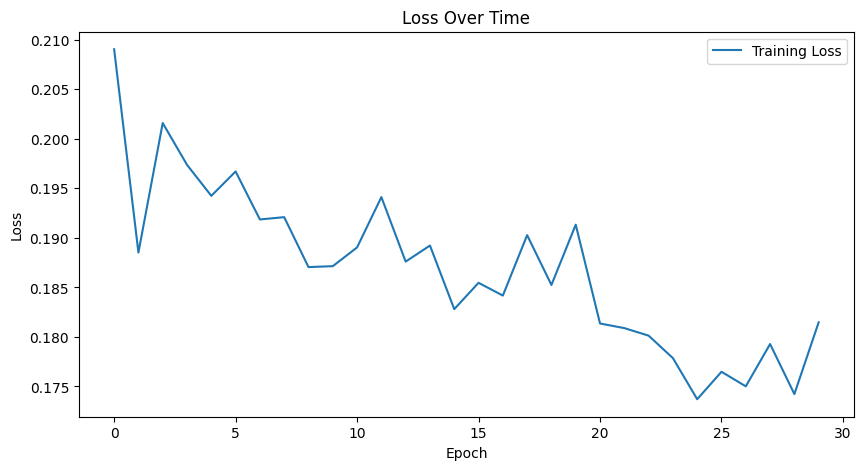

In [ ]:
# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Part 4: Examining Results
In this section, we're plotting the model's predictions versus the actual price point for the commodity in question. However, one plot focuses specifically on the testing data only (this is a better plot to see how well the model is performing/generalizing) and the other focuses on the entire dataset (this is a better plot to see if the model is correlating to the provided dataset at all).

Therefore, when **evaluating the performance** of the model, **the first plot should be used.** 

Mean Absolute Error: 0.13691586798355396


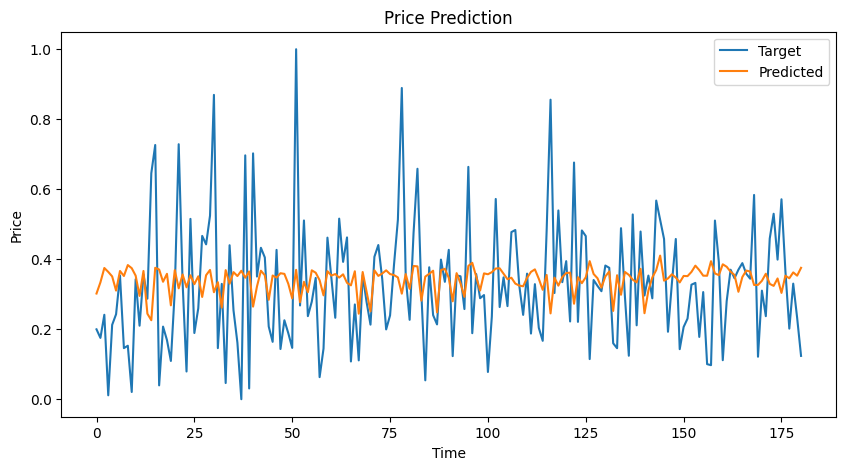

In [ ]:
from sklearn.metrics import mean_absolute_error

# Evaluate the performance of the model on the reserved testing set
model.eval()

# Make predictions using a DataLoader for consistency
test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

all_predictions = []
all_targets = []

with torch.no_grad():
    for inputs, target in test_loader:
        # print("INPUTS: ", inputs.shape)
        # print("TARGET: ", target.shape)
        prediction = model(inputs) # Ensure output has the same shape as targets
        all_predictions.append(prediction.item())
        all_targets.append(target.item())
        # print("PREDICTION: ", prediction.item())

# Calculate the mean absolute error of the model
mae = mean_absolute_error(all_targets, all_predictions)
print(f"Mean Absolute Error: {mae}")

# Plot the predictions against the actual values
plt.figure(figsize=(10, 5))
plt.plot(all_targets, label='Target')
plt.plot(all_predictions, label='Predicted')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


Mean Absolute Error: 0.12944052071180118


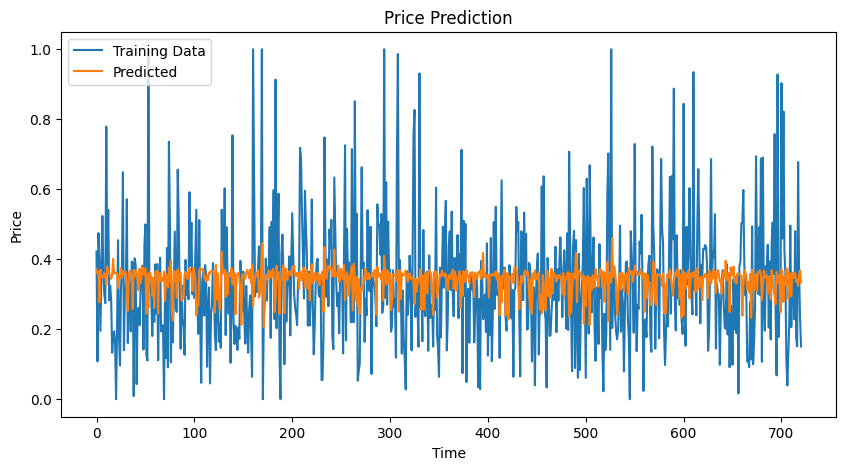

In [ ]:
from sklearn.metrics import mean_absolute_error

# Evaluate the performance of the model on the reserved testing set
model.eval()

# Make predictions using a DataLoader for consistency
test_dataset = TimeSeriesDataset(X_train, y_train)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

all_predictions = []
all_targets = []

with torch.no_grad():
    for inputs, target in test_loader:
        # print("INPUTS: ", inputs.shape)
        # print("TARGET: ", target.shape)
        prediction = model(inputs) # Ensure output has the same shape as targets
        all_predictions.append(prediction.item())
        all_targets.append(target.item())
        # print("PREDICTION: ", prediction.item())

# Calculate the mean absolute error of the model
mae = mean_absolute_error(all_targets, all_predictions)
print(f"Mean Absolute Error: {mae}")

# Plot the predictions against the actual values
plt.figure(figsize=(10, 5))
plt.plot(all_targets, label='Training Data')
plt.plot(all_predictions, label='Predicted')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
